In [215]:
# load data from csv file and save data into separate lists
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

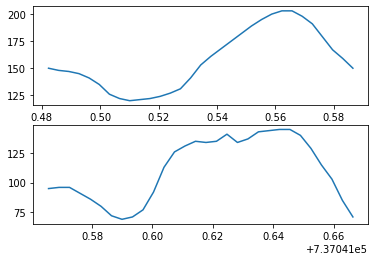

In [216]:
# this part is just showing what is the figures look like and 
i = 0
a = pd.read_csv('.\DataFolder\CGMDatenumLunchPat'+str(i+1)+'.csv')
b = pd.read_csv('.\DataFolder\CGMSeriesLunchPat'+str(i+1)+'.csv')
plt.figure(1)
plt.subplot(211)
plt.plot(a.iloc[22],b.iloc[22])
plt.subplot(212)
plt.plot(a.iloc[23],b.iloc[23])
plt.show()

In [217]:
# when read the data from CSV, the time stamp and associated GMC value should be reversed
def read_raw_data():
    x =[]
    y =[]

    for i in range (5):
        x_p=[]
        y_p=[]
        with open(r'.\DataFolder\CGMDatenumLunchPat'+str(i+1)+'.csv','rt')as f:
            data = csv.reader(f)
#             rows_x=[row for idx, row in enumerate(data) if idx<=20]# only use first 20 rows of the data
            for row in data:
                x_p.append(row[::-1])
        with open(r'.\DataFolder\CGMSeriesLunchPat'+str(i+1)+'.csv','rt')as ff:
            data = csv.reader(ff)
#             rows_y=[row for idx, row in enumerate(data) if idx<=20]# only use first 20 rows of the data
            for row in data:
                y_p.append(row[::-1])
        if i==0:
            x = x_p[1:]
            y = y_p[1:]
        elif i!=0:
            x = x+x_p[1:]
            y = y+y_p[1:]
    return x,y
        

# this func is used to remove the data which contains 'NaN' and only use the first 30 data
def smooth_data(x,y):
    idx = []
    size_y = len(y)
#     print("size: ", size_y)
    for i in range (size_y):
        x[i] = x[i][:30]
        y[i] = y[i][:30]
        if 'NaN' in y[i]:
#             print('here',i)
            idx.append(i)
#     print(idx)        
    for j in range (len(idx),0,-1):
        del y[idx[j-1]]
        del x[idx[j-1]]
    return x,y

In [218]:
x,y = read_raw_data()
print('Number of rows from the raw data:',len(y))

x,y = smooth_data(x,y)
print("Number of rows from the processed data: ",len(y) )

Number of rows from the raw data: 216
Number of rows from the processed data:  186


In [220]:
print(len(y[40]))
array_x = np.asarray(x[0])
array_y = np.asarray(y[0],dtype=int)
print(array_y)
print(x[0])

30
[ 91  92  91  90  91  91  97  99  98  99  99 102 113 131 146 163 179 194
 207 213 221 228 236 241 246 252 254 258 260 258]
['737225.479988426', '737225.483460648', '737225.48693287', '737225.490405093', '737225.493877315', '737225.497349537', '737225.500821759', '737225.504293981', '737225.507766204', '737225.511238426', '737225.514710648', '737225.51818287', '737225.521655093', '737225.525127315', '737225.528599537', '737225.532071759', '737225.535543981', '737225.539016204', '737225.542488426', '737225.545960648', '737225.54943287', '737225.552905093', '737225.556377315', '737225.559849537', '737225.563321759', '737225.566793981', '737225.570266204', '737225.573738426', '737225.577210648', '737225.58068287']


In [225]:
xx = np.arange(30)
z = np.polyfit(xx, array_y, 6)
print(z)

[ 1.39467479e-06  6.48684562e-05 -1.02063996e-02  2.95690841e-01
 -2.61404589e+00  7.58331515e+00  8.77494049e+01]
